# Study of a Facebook messenger conversation

In [50]:
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()

In [51]:
from bs4 import BeautifulSoup
import urllib

yourName = 'Thomas Marchand'
url = r"messages/23.html"
page = open(url, encoding="utf8")
soup = BeautifulSoup(page.read(), 'lxml')


## Getting the conversation name & participants

In [52]:
def getConvName(soup):
    nameConv = soup.h3.get_text()
    return(nameConv)

In [53]:
def getListParticipants(soup):
    
    def getStringParticipants(soup):
        stringClassThread = str(soup\
                            .find_all("div", class_="thread")
                           )
        intermediate = stringClassThread.split('</h3>')
        return(intermediate[1]\
               .split('<div class="message">')[0]
              )
    
    stringClassThread = str(soup\
                        .find_all("div", class_="thread")
                       )
    stringParticipants = getStringParticipants(soup)
    listParticipants = stringParticipants.split(",")
    listParticipants[0] = listParticipants[0].split(":")[1]
    listParticipants = [Participant[1:] 
                    for Participant in listParticipants]
    listParticipants.append(yourName)
    return(listParticipants)

#### tests:

In [54]:
getConvName(soup)

"Conversation avec L'avènement des Thomas "

In [55]:
userList = getListParticipants(soup)
userList

['Guillaume Duponchel',
 'Augustin Borelle',
 'Roxane Timmerman',
 'Thomas Kerleroux',
 'Thomas Quandalle',
 'Élisa Lcs',
 'Thomas Marchand']

## Getting the number of messages in total and per users

In [56]:
def getNumberOfMessage(soup):
    return(len(soup.find_all("div", class_="message")))

In [57]:
def getNumberOfMessgePerUser(soup, userList):
    userActivityDict = {u:0 for u in userList}
    allMessages = (soup\
           .find_all("div", class_="message"))
    for i in range(getNumberOfMessage(soup)):
        tempWriter = allMessages[i]\
                .find_all("span", class_="user")[0]\
                .get_text()
        if tempWriter not in userActivityDict:
            userActivityDict[tempWriter] = 0
        userActivityDict[tempWriter] += 1
    return(userActivityDict)

#### tests:

In [58]:
getNumberOfMessage(soup)

9291

In [59]:
NumberOfMessgePerUser = getNumberOfMessgePerUser(soup, userList)

In [60]:
NumberOfMessgePerUserDF = pd.DataFrame(data =list(NumberOfMessgePerUser.values()) , \
                                       index = list(NumberOfMessgePerUser.keys()), \
                                       columns=['nbMessage'])

In [61]:
NumberOfMessgePerUserDF

,nbMessage
Guillaume Duponchel,507
Augustin Borelle,1385
Roxane Timmerman,861
Thomas Kerleroux,1897
Thomas Quandalle,2132
Élisa Lcs,695
Thomas Marchand,1814


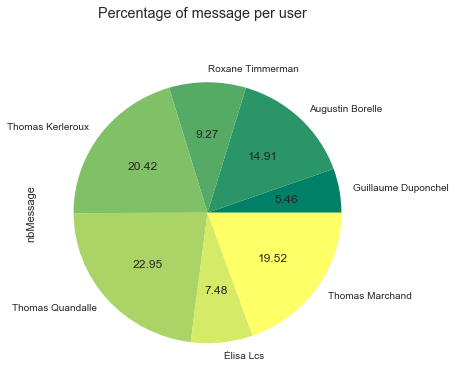

In [62]:
NumberOfMessgePerUserDF.plot.pie(title = 'Percentage of message per user'\
                                 ,subplots = True, legend = False\
                                 ,figsize=(6, 6),\
                                 cmap = "summer"\
                                , autopct='%.2f');

## About pictures

In [63]:
def getNumPicturePerUser(soup):
    userList = getListParticipants(soup)
    userActivityDict = {u:0 for u in userList}
    allMessages = (soup\
           .find_all("div", class_="message"))
    for i in range(getNumberOfMessage(soup)):
        if (str(allMessages[i].find_next("p")\
                .find_next("p")).split()[0] == '<p><img'):
            tempWriter = allMessages[i]\
                .find_all("span", class_="user")[0]\
                .get_text()
            if tempWriter not in userActivityDict:
                userActivityDict[tempWriter] = 0
            userActivityDict[tempWriter] += 1
    return(userActivityDict)

In [64]:
NumberOfPicturePerUser = getNumPicturePerUser(soup)

In [65]:
NumberOfPicturePerUserDF = pd.DataFrame(data =list(NumberOfPicturePerUser.values()) \
                                        , index = list(NumberOfPicturePerUser.keys())\
                                        , columns=['nbPicture'])
NumberOfPicturePerUserDF

,nbPicture
Guillaume Duponchel,13
Augustin Borelle,29
Roxane Timmerman,26
Thomas Kerleroux,122
Thomas Quandalle,71
Élisa Lcs,21
Thomas Marchand,70


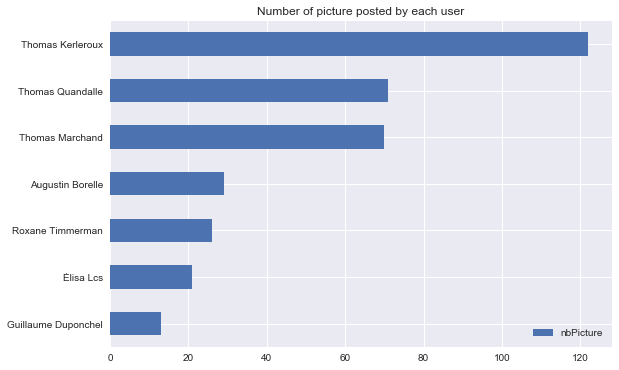

In [66]:
NumberOfPicturePerUserDF.sort_values(by=["nbPicture"])\
                    .plot.barh(title ='Number of picture posted by each user'\
                   ,figsize=(9,6));

## Time analysis

In [67]:
from datetime import datetime, timedelta
import locale
locale.setlocale(locale.LC_ALL,'')
locale.getlocale()

('fr_FR', 'cp1252')

In [68]:
def getDateTime(dateString):
    dateString = dateString.find_next("span", class_="meta").get_text()
    dateListWithoutTimezone = dateString.split()[:-1]
    dateStringWithoutTimezone = " ".join(dateListWithoutTimezone)
    return(datetime.strptime(dateStringWithoutTimezone, '%A %d %B %Y, %H:%M'))

def add_one_month(dt0):
    dt1 = dt0.replace(day=1)
    dt2 = dt1 + timedelta(days=32)
    dt3 = dt2.replace(day=1)
    return dt3

In [69]:
def getNumberOfMessgePerUserPerMonth(soup, userList, dateTimeObject):
    userActivityDict = {u:0 for u in userList}
    allMessages = (soup\
           .find_all("div", class_="message"))
    startDate = dateTimeObject.replace(day=1)
    endDate = add_one_month(startDate)
    allMessageInTimeRegion = [m for m in allMessages if ((getDateTime(m)>startDate) & (getDateTime(m)< endDate))]
    for i in range(len(allMessageInTimeRegion)):
        tempWriter = allMessageInTimeRegion[i]\
                .find_all("span", class_="user")[0]\
                .get_text()
        if tempWriter not in userActivityDict:
            userActivityDict[tempWriter] = 0
        userActivityDict[tempWriter] += 1
    return(userActivityDict, startDate)

def createMonthDataframe(userActivityDict, startDate):
    d = str(startDate.month) + "/" + str(startDate.year)
    return( pd.DataFrame(data =list(userActivityDict.values()) \
                                        , columns = [d]\
                                        , index=list(userActivityDict.keys())).transpose())

In [70]:
def createYearDataframe(soup, userList, year):
    listOfDateTime = [datetime(year,i,1) for i in range(1,13)]
    a,b = getNumberOfMessgePerUserPerMonth(soup, userList, listOfDateTime[0])
    DF = createMonthDataframe(a,b)
    for j in range(1,12):
        a,b = getNumberOfMessgePerUserPerMonth(soup, userList, listOfDateTime[j])
        DFTemp = createMonthDataframe(a,b)  
        DF = pd.concat([DF, DFTemp])
    return(DF)

In [71]:
df = createYearDataframe(soup, userList, 2017)

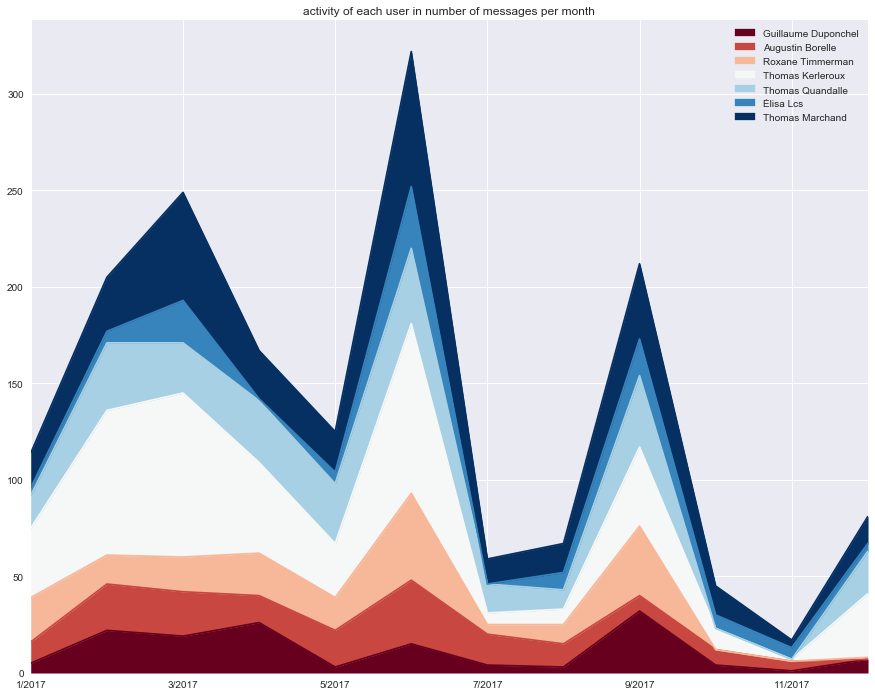

In [73]:
df.plot.area(figsize=(15,12), title ='activity of each user in number of messages per month', cmap ="RdBu");